In [65]:
import sys, os
import pathlib
import time
import importlib
import joblib
import pickle
from tqdm import tqdm

import numpy as np

from scipy.linalg import null_space
from scipy.sparse import csr_matrix

import matplotlib.pyplot as plt

import cv2

In [66]:
%load_ext autoreload
%autoreload 2

if not os.path.abspath("../") in sys.path:
    sys.path.append(os.path.abspath("../"))
    sys.path.append(os.path.abspath("../src"))

from src import normalization
from src import Camera, metashape_Camera
from src import camera_correspondence, FF_mat, epipole_angle, pair_and_key_gen, coll_dict_gen, pair_pt_gen
from src import FR_check, coordinate_dict_gen
from src import min_dist, tri, TDlines_gen, reprojection_gen, gen_support_dict, gen_support
from src import all_D, frag_list_fraged, all_sep

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## パイプライン

In [191]:
img_num = 128
individual = "q_2"

In [192]:
cam_list = [Camera(i) for i in range(img_num)]
for i in range(len(cam_list)):
    cam_list[i].img_load("images/quantitative/{}/{}".format(individual, str(img_num)))
    cam_list[i].contour_extraction()
    cam_list[i].label_load("preprocessing/labels/{}/{}_{}_label.pickle".format(individual, individual, str(img_num)))
    cam_list[i].correspondence_contour()
    cam_list[i].para_load("view_mats/view_mat_{}/{}.csv".format(str(img_num), str(i)))


In [193]:
kernel = np.ones((3,3),np.uint8)

for cnum in range(len(cam_list)):
    sparse_mats_list = []
    for j in range(len(cam_list[cnum].contour_list)):
        new_img = np.zeros((cam_list[0].img.shape[0],cam_list[0].img.shape[1]),dtype=np.uint8)
        for i in range(len(cam_list[cnum].contour_list[j])):
            curve = cam_list[cnum].contour_list[j][i][~np.isnan(cam_list[cnum].contour_list[j][i])].reshape((-1,2)).astype(int)
            new_img[curve[:,1],curve[:,0]]=True
        dilation = cv2.dilate(new_img, kernel, iterations = 10)
        new_img = csr_matrix(dilation, dtype=np.uint8)
        sparse_mats_list.append(new_img)
        
    cam_list[cnum].contour_img = sparse_mats_list

In [194]:
# エピポール取得
b = 40
cam_pairs = camera_correspondence(cam_list,angle_upper=b / 180 * np.pi)

epipole_dict = {i:[] for i in range(len(cam_list))}
cam_pairs_F = {}
for i in cam_pairs:
    epipole1, epipole2, F = FF_mat(cam_list[i[0]].A, cam_list[i[1]].A, cam_list[i[0]].Rt, cam_list[i[1]].Rt)
    epipole_dict[i[0]].append(normalization(epipole1))
    epipole_dict[i[1]].append(normalization(epipole2))
    cam_pairs_F[i] = F
print(len(cam_pairs))

1312


In [195]:
# フラグメントのリストを作る
for i in range(len(cam_list)):
    im_del_list = all_D(epipole_angle(i, epipole_dict, cam_list=cam_list))# im_del_list[color][contour][del_idx]
    newCon = all_sep(cam_list[i].contour_list, im_del_list)# newCon[color][fragment][coordination]
    cam_list[i].frag_list = frag_list_fraged(newCon)

del epipole_dict

C:\home\study\git_test\curve_sketch\src\epipolar.py:55: RuntimeWarning: invalid value encountered in double_scalars
  return list(map(lambda y: (y - min(B)) / (max(B) - min(B)), B))


In [196]:
#cnum = 4
#new_img = np.zeros((cam_list[0].img.shape[0],cam_list[0].img.shape[1]),dtype=np.bool8)
#
#for j in range(len(cam_list[cnum].frag_list)):
#    for i in range(len(cam_list[cnum].frag_list[j])):
#        curve = cam_list[cnum].frag_list[j][i][~np.isnan(cam_list[cnum].frag_list[j][i])].reshape((-1,2)).astype(int)
#        new_img[curve[:,1],curve[:,0]]=True

In [197]:
#%matplotlib inline
#fig = plt.figure(figsize = (20, 20))
#fig.patch.set_alpha(0.)
## 3DAxesを追加
#ax = fig.add_subplot(111)
#plt.imshow(new_img)

## ペア生成

In [198]:
%%time
_ = joblib.Parallel(n_jobs=-1, verbose=10)(joblib.delayed(pair_and_key_gen)(i, cam_list, cam_pairs_F) for i in cam_pairs_F)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   38.3s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  9.6min
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed: 12.2min
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed: 1

Wall time: 1h 30min 46s


In [199]:
temp_path = pathlib.Path("temp/")
tags_path = list(temp_path.glob("*.pair_list"))

tags = []
for tag_path in tags_path:
    tag_sp = tag_path.stem.split("_")
    tag_arr = ((int(tag_sp[0]), int(tag_sp[1])), tag_sp[2])
    tags.append(tag_arr)

In [200]:
%%time
_ = joblib.Parallel(n_jobs=-1, verbose=10)(joblib.delayed(coll_dict_gen)(i, cam_list, cam_pairs_F) for i in tags)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   38.3s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed: 11.2min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed: 12.6min
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed: 1

Wall time: 1h 35min 46s


[Parallel(n_jobs=-1)]: Done 1312 out of 1312 | elapsed: 95.8min finished


In [201]:
_ = joblib.Parallel(n_jobs=-1, verbose=10)(joblib.delayed(pair_pt_gen)(i) for i in tags)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   24.9s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   28.1s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   40.1s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   49.6s
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   54.6s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  1.4min
C:\Users\murata\anaconda3\envs\py37cv\lib\site-packages\joblib\externals\loky\process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. Th

In [202]:
_ = joblib.Parallel(n_jobs=-1, verbose=10)(joblib.delayed(coordinate_dict_gen)(i, cam_list=cam_list) for i in tags)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   35.8s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed: 12.1min
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed: 1

## 3次元再構築

In [203]:
result = joblib.Parallel(n_jobs=-1,verbose=10)(joblib.delayed(TDlines_gen)(
    tag, cam_list=cam_list, cam_pairs_F=cam_pairs_F) for tag in tags)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed: 10.5min
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed: 14.1min
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed: 16.3min
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed: 18.9min
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed: 22.8min
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed: 25.6min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed: 29.0min
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed: 33.2min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed: 36.5min
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed: 4

In [204]:
%%time
result = joblib.Parallel(n_jobs=-1,verbose=10)(joblib.delayed(reprojection_gen)(tag, cam_list=cam_list) for tag in tags)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   55.1s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed: 11.5min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed: 13.0min
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed: 14.8min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed: 16.5min
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed: 1

Wall time: 2h 15min 26s


[Parallel(n_jobs=-1)]: Done 1312 out of 1312 | elapsed: 135.4min finished


In [205]:
temp_path = pathlib.Path("temp/")
tags_path = list(temp_path.glob("*.reprojection_dict"))

tags = []
for tag_path in tags_path:
    tag_sp = tag_path.stem.split("_")
    tag_arr = ((int(tag_sp[0]), int(tag_sp[1])), tag_sp[2])
    tags.append(tag_arr)

In [206]:
result = joblib.Parallel(n_jobs=-1,verbose=10)(joblib.delayed(gen_support)(tag, cam_list=cam_list) for tag in tags)
#4.1min finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed: 10.5min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 22.2min
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed: 29.3min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 42.3min
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed: 49.3min
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed: 64.7min
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed: 77.2min
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed: 90.2min
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed: 106.4min
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed: 125.7min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed: 144.0min
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed: 164.0min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed: 181.0min
[Parallel(n_jobs=-1)]: Done 197 tasks      | elaps

In [207]:
sup_th = 15# サポート数
curve_fragment = []
for tag in tags:
    if tag[1] == "R":
        continue
    
    with open(r"temp/{0}_{1}_{2}.TDlines".format(tag[0][0],tag[0][1],tag[1]), 'rb') as f:
        lines_list = pickle.load(f)
    #lines_list = TDlines[tag]
    
    with open(r"temp/{0}_{1}_{2}.support_dict".format(tag[0][0],tag[0][1],tag[1]), 'rb') as f:
        support_list, support_ac = pickle.load(f)
    #support_list, support_ac = support_dict[tag][0], support_dict[tag][1]
    tag_list = []
    for col, sup_col, ac_col in zip(lines_list, support_list, support_ac):
        col_curve_fragment = []
        for frag, sup, sup_ac in zip(col, sup_col, ac_col):
            if sup > sup_th:
                frag = np.reshape(frag,(-1, 3))
                frag = np.array([i for i,j in zip(frag, sup_ac >sup_th) if j])
                col_curve_fragment.append(frag)
        tag_list.append(col_curve_fragment)
    curve_fragment.append(tag_list)

In [208]:
cfs = [[],[],[],[],[],[],[],[],[]]
for cols in curve_fragment:
    for i in range(len(cols)):
        if i == 0:
            cfs[0] += cols[i]
        if i == 1:
            cfs[1] += cols[i]
        if i == 2:
            cfs[2] += cols[i]
        if i == 3:
            cfs[3] += cols[i]
        if i == 4:
            cfs[4] += cols[i]
        if i == 5:
            cfs[5] += cols[i]
        if i == 6:
            cfs[6] += cols[i]
        if i == 7:
            cfs[7] += cols[i]
        if i == 8:
            cfs[8] += cols[i]

In [209]:
from scipy import interpolate
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
# %matplotlib notebook

def plot_graph():
    color_arr = np.array([[255,0,0],[0,255,0],[0,0,255],
                             [255,255,0],[255,0,255],[0,255,255],
                             [127,127,127],[127,0,127],[0,127,127]],dtype = np.int16)
    j = 0
    for i in range(len(cfs)):
        for frag in cfs[i]:
            if frag.size < 10:
                continue
            #if i != 4:
            #    continue
            
            x = frag[:,0]
            y = frag[:,1]
            z = frag[:,2]
            data = [x,y,z]
            try:
                tck, u= interpolate.splprep(data, k=3)
            except ValueError:
                pass
            except TypeError:
                pass
            except UnboundLocalError:
                pass
            new = interpolate.splev(u, tck, der=0)
            c = color_arr[i]/255
            if j % 10 == 0:
                ax.plot(new[0], new[2], new[1],"-",color=c)
            
            j+=1


In [210]:
%matplotlib notebook

<IPython.core.display.Javascript object>


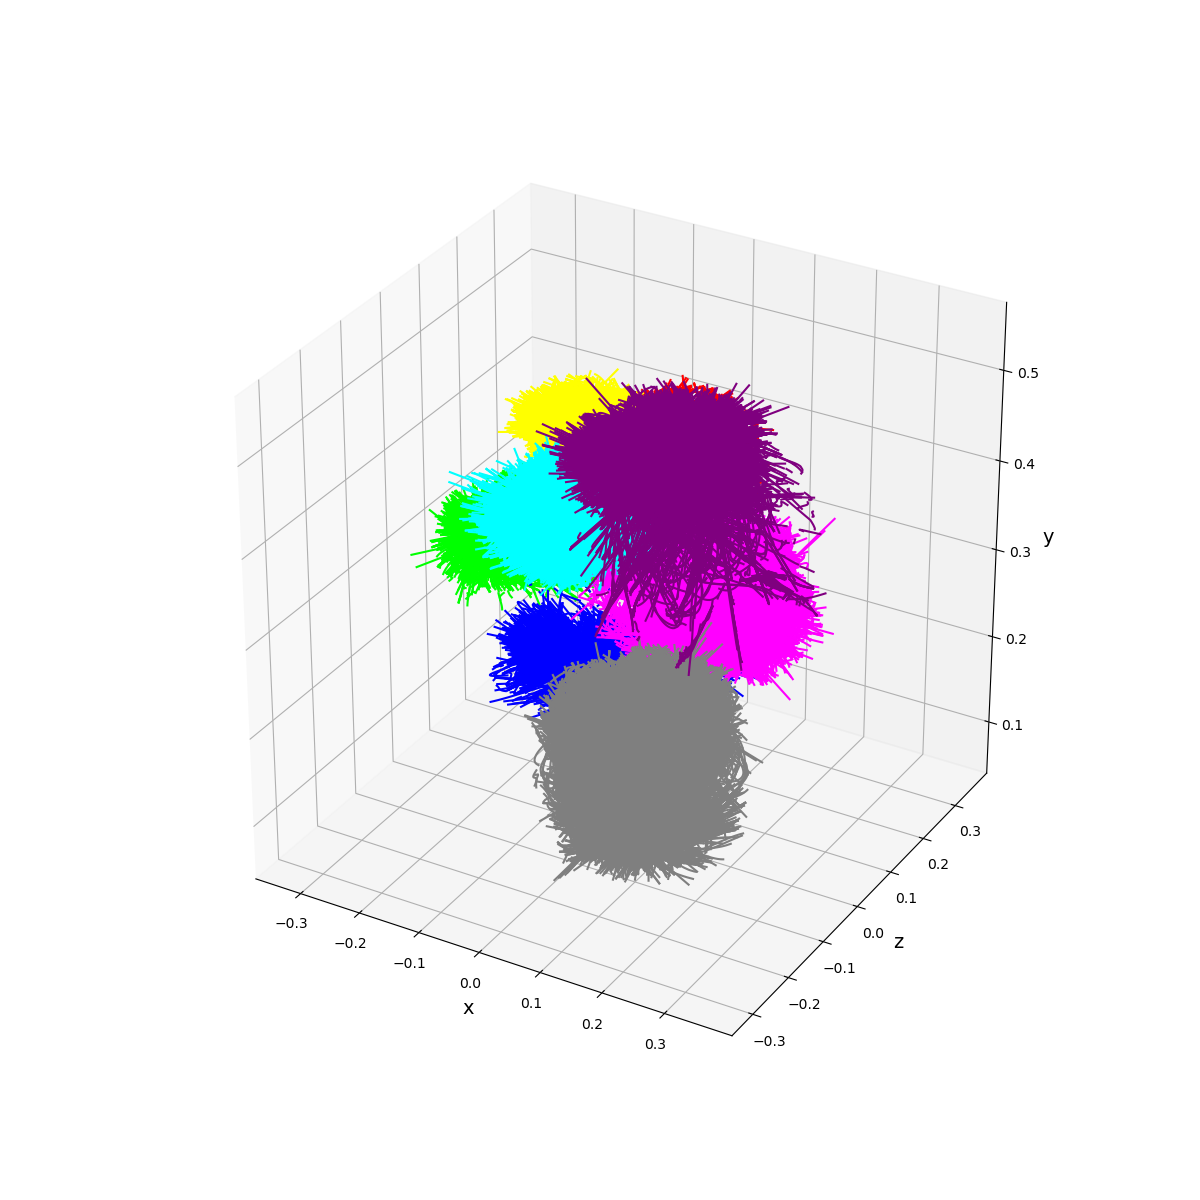

In [211]:
fig = plt.figure(figsize = (12, 12))
fig.patch.set_alpha(0.)
# 3DAxesを追加
ax = fig.add_subplot(111, projection='3d')

# 軸ラベルを設定
ax.set_xlabel("x", size = 14)
ax.set_ylabel("z", size = 14)
ax.set_zlabel("y", size = 14)
ax.set_box_aspect((1,1,1))
#ax.set_xticks(np.arange(-4,4,1))
#ax.set_yticks(np.arange(-4,4,1))
#ax.set_zticks(np.arange(-2,9,1))

plot_graph()

In [188]:
import itertools

import open3d as o3d

flatten_curve_frag = np.array(list(itertools.chain.from_iterable(_curve_fragment)))
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(flatten_curve_frag)

o3d.visualization.draw_geometries([pcd])

from scipy import interpolate
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

fig = plt.figure(figsize = (12, 12))
fig.patch.set_alpha(0.)
### 3DAxesを追加
ax = fig.add_subplot(111, projection='3d')

### 軸ラベルを設定
ax.set_xlabel("x", size = 14)
ax.set_ylabel("z", size = 14)
ax.set_zlabel("y", size = 14)
ax.set_box_aspect((1,1,1))

def plot_graph():
    i = 0
    for c_f in curve_fragment:
        for frag in c_f:
            if frag.size == 0:
                continue
            #print(frag)
            
            if i%100 == 0:
                x = frag[:,0]
                y = frag[:,1]
                z = frag[:,2]
                data = [x,y,z]
                try:
                    tck, u= interpolate.splprep(data, k=3)
                except ValueError:
                    pass
                except TypeError:
                    pass
                new = interpolate.splev(u, tck, der=0)

                ax.plot(new[0], new[2], new[1],"-")
                    #ax.plot(x, z, y,"-")
            i += 1

def plt_graph3d(angle):
    ax.view_init(azim=angle*5)
    
### アニメーションを作成
ani = FuncAnimation(
    fig,
    func=plt_graph3d,
    frames=72,
    init_func=plot_graph,
    interval=200
)

### imagemagickで作成したアニメーションをGIFで書き出す
ani.save("48_rolling.gif", writer="pillow", savefig_kwargs={'transparent': True, 'facecolor': 'none'})
#ani.save('48_anim.mp4', writer="ffmpeg", savefig_kwargs={'transparent': True, 'facecolor': 'none'})

In [189]:
import pickle
with open("postprocessing/curves_by/q_curves/{}/{}_b{}_s{}_lmin40_lmax_100_o15.curves".format(
    individual, str(img_num), str(b), str(sup_th)),"wb") as f:
    pickle.dump(curve_fragment, f)

In [190]:
import os
import shutil
target_dir = "temp"

shutil.rmtree(target_dir)
os.mkdir(target_dir)